# Import Library

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import string
from scipy.stats import zscore
from tqdm import tqdm
from collections import defaultdict

# Untuk Text Preprocessing (akan digunakan di tahap Data Preparation lanjut)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Untuk Modeling (akan digunakan di tahap Modeling)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Understanding

In [152]:
df = pd.read_csv('/content/data_books.csv')
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


* Melihat ukuran data

In [153]:
# Melihat jumlah baris dan kolom
num_rows, num_cols = df.shape
print(f"\n--- Ukuran Data ---")
print(f"Jumlah baris (entri buku): {num_rows}")
print(f"Jumlah kolom (fitur): {num_cols}")


--- Ukuran Data ---
Jumlah baris (entri buku): 6810
Jumlah kolom (fitur): 12


* Melihat tipe data

In [154]:
print("\n--- Tipe Data Setiap Kolom ---")
print(df.info())


--- Tipe Data Setiap Kolom ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB
None


Insight: informasi di atas memberikan beberapa informasi yaitu terdapat 10 kolom (fitur) , 6810 baris (entri buku), dan tipe data dari setiap fitur.

In [155]:
# Melihat missing value
df.isnull().sum()
print("Jumlah missing values dalam setiap kolom:")
print(df.isnull().sum())

Jumlah missing values dalam setiap kolom:
isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
dtype: int64


Insight:
Setelah dilakukan pengecekan terlihat bahwa terdapat banyak missing value pada beberapa fitur. Oleh karena itu, handling missing value menjadi hal penting yang akan dilakukan pada tahap preparation.

In [156]:
# Melihat dan Handling Data Duplikat
num_duplicates = df.duplicated().sum()
print(f"\nJumlah duplikasi data: {num_duplicates}")


Jumlah duplikasi data: 0


Insight: tidak terdapat data duplikasi

## Exploratory Data Analysis (EDA)

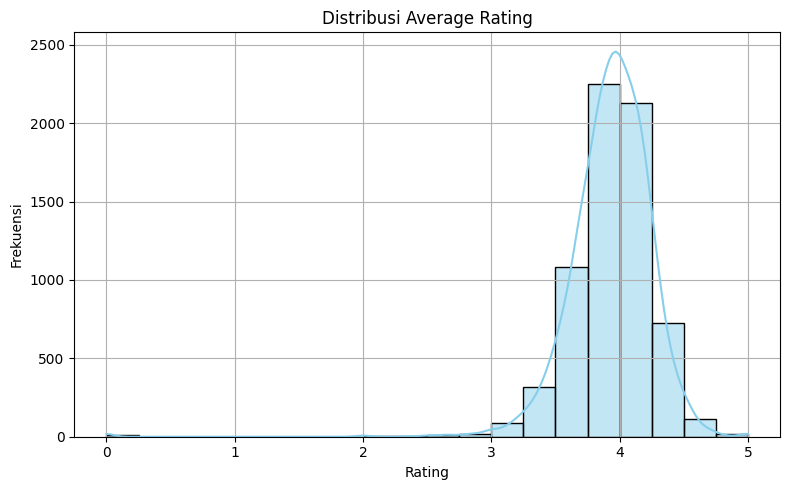

In [157]:
# Distribusi Rating menggunakan raw data sebelum handling outlier

plt.figure(figsize=(8, 5))
sns.histplot(df['average_rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Average Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

Insight:
* Distribusi Miring ke Kiri (Left-Skewed): Kotak dan median berada di bagian atas rentang data, dan whisker bawah jauh lebih pendek daripada rentang outlier di bawahnya. Ini menegaskan bahwa distribusi data miring ke kiri, dengan konsentrasi data di nilai-nilai tinggi.
* Kualitas Rata-rata Cukup Tinggi: Median di 4.0 menunjukkan bahwa setengah dari "Average Rating" berada di atau di atas 4.0, menunjukkan kualitas yang umumnya baik.

<ipython-input-158-a9c8f0769a31>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='title', data=top_rated_books, palette='coolwarm')


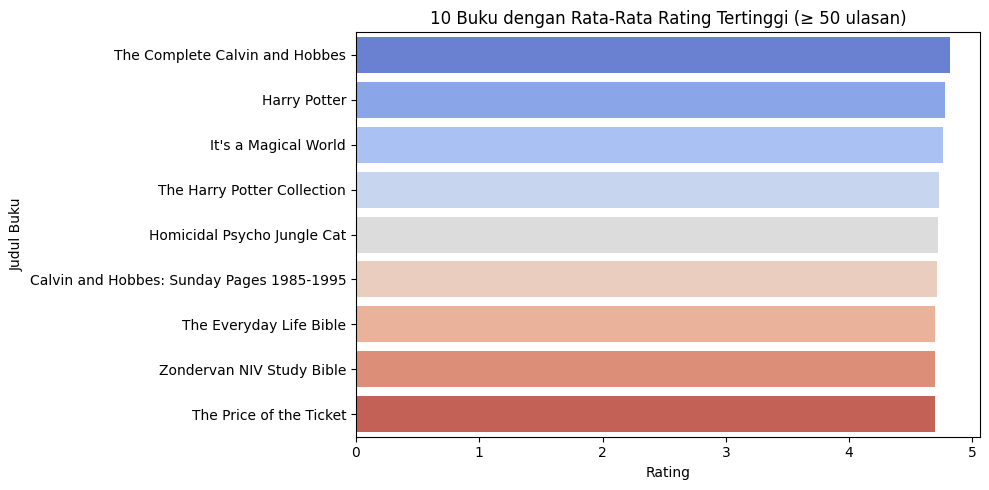

<ipython-input-158-a9c8f0769a31>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ratings_count', y='title', data=most_reviewed_books, palette='flare')


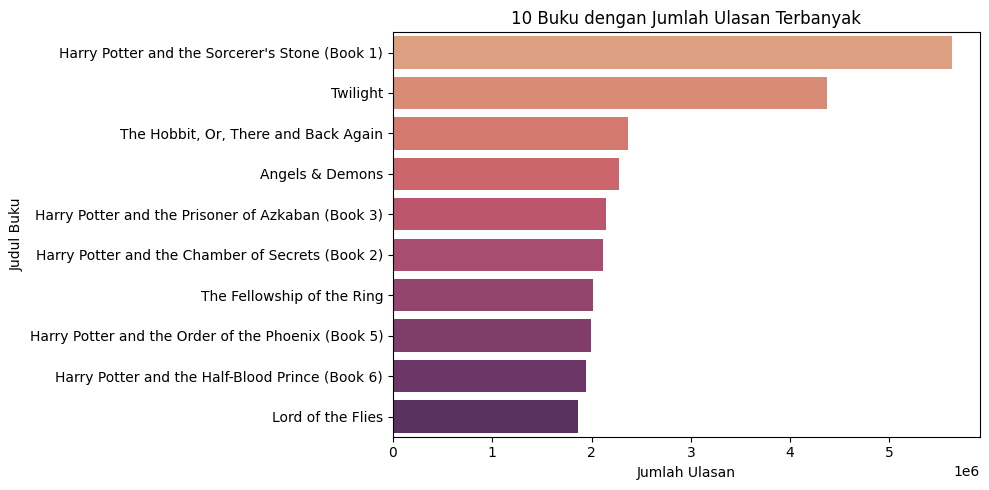

In [158]:
# BUKU TERPOPULER (berdasarkan rata-rata rating tertinggi dan ulasan terbanyak)
top_rated_books = df[df['ratings_count'] > 50].sort_values(by='average_rating', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='average_rating', y='title', data=top_rated_books, palette='coolwarm')
plt.title('10 Buku dengan Rata-Rata Rating Tertinggi (≥ 50 ulasan)')
plt.xlabel('Rating')
plt.ylabel('Judul Buku')
plt.tight_layout()
plt.show()

most_reviewed_books = df.sort_values(by='ratings_count', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='ratings_count', y='title', data=most_reviewed_books, palette='flare')
plt.title('10 Buku dengan Jumlah Ulasan Terbanyak')
plt.xlabel('Jumlah Ulasan')
plt.ylabel('Judul Buku')
plt.tight_layout()
plt.show()

Insight:
- Buku dengan rating tinggi umumnya memiliki banyak ulasan dan menunjukkan popularitasnya. Buku dengan rating tertinggi berjudul "The Complete Calvin and Hobbes"
- Buku populer dengan jumlah ulasan terbanyak berjudul "Harry Potter and the Sorcerer's Stone (Book 1)

<ipython-input-159-74a4a0edb403>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')


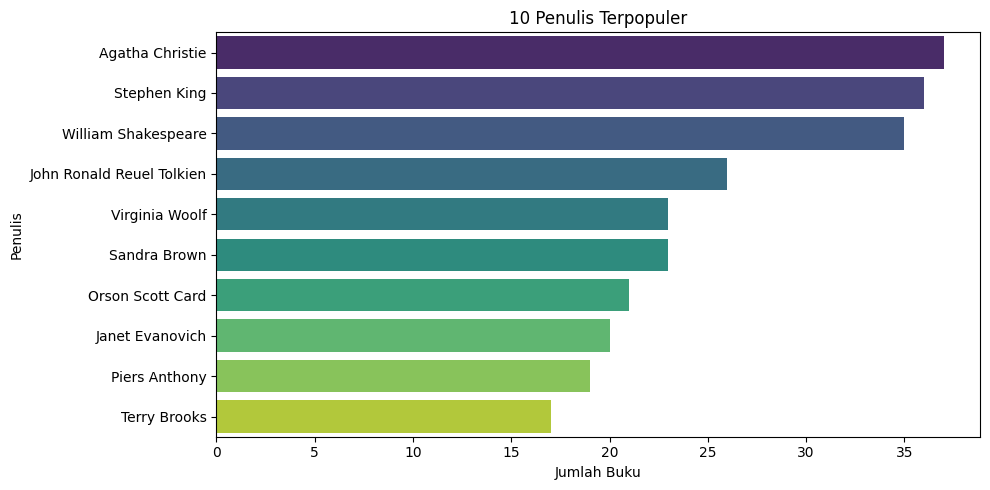

<ipython-input-159-74a4a0edb403>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='magma')


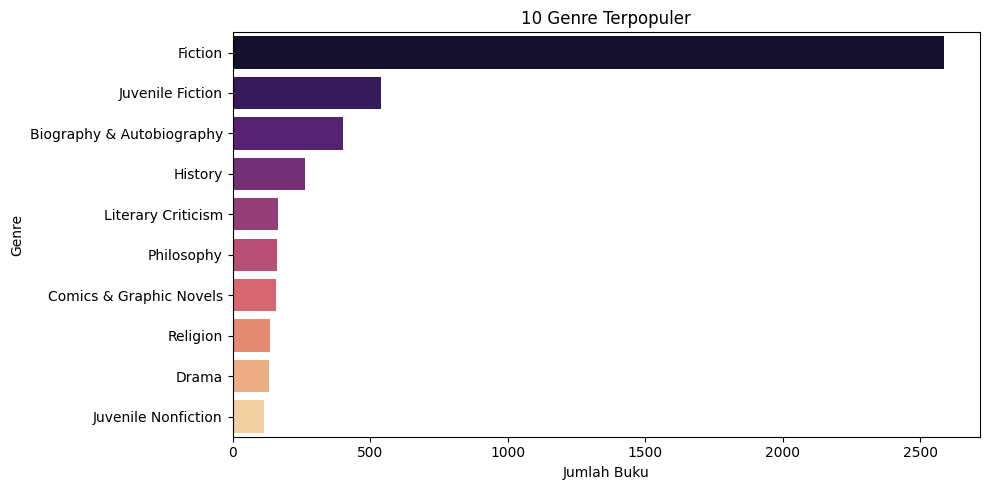

In [159]:
# Frekuensi Penulis dan Genre (Top 10)
top_authors = df['authors'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')
plt.title('10 Penulis Terpopuler')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.tight_layout()
plt.show()

top_categories = df['categories'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='magma')
plt.title('10 Genre Terpopuler')
plt.xlabel('Jumlah Buku')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Insight:
* Daftar 10 penulis terpopuler justru dinobatkan kepada author yang tidak diketahui (Unknown Author).
* Daftar 10 genre terpopuler adalah fiksi dengan banyak pengguna yang menyukai genre fiksi ada sekitar 2500 orang.

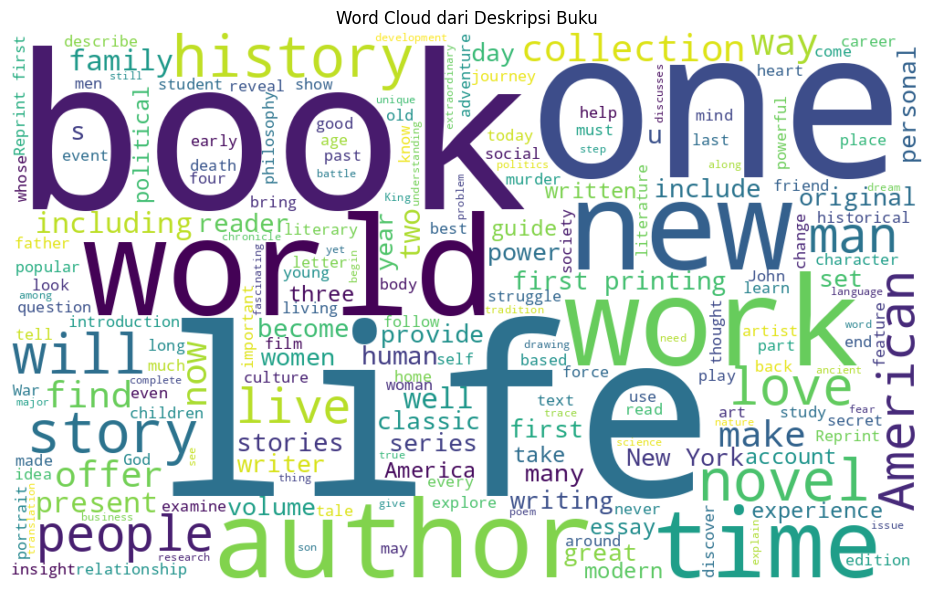

In [236]:
# Word cloud dari deskripsi buku
text_corpus = ' '.join(df['description'].dropna().astype(str).values)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1000, height=600).generate(text_corpus)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Deskripsi Buku')
plt.tight_layout()
plt.show()

Insight Word Cloud:
- Word cloud menampilkan kata-kata umum yang sering muncul dalam deskripsi, seperti, 'life', 'one', 'book', 'novel', 'world', 'stroynew', 'work'.

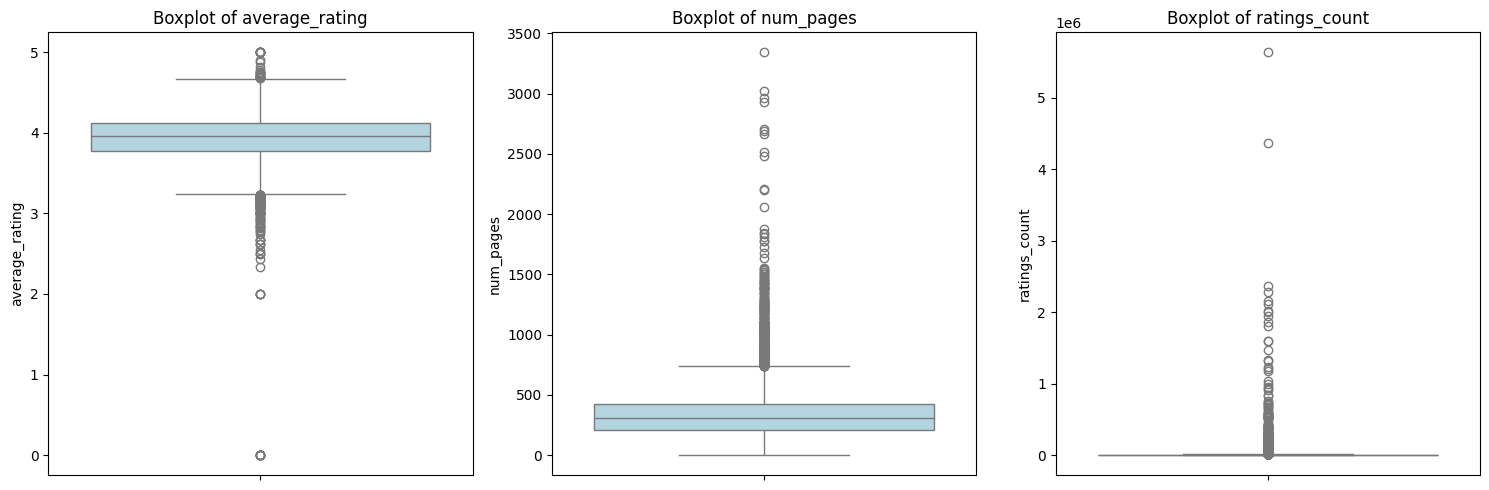

In [160]:
# Menampilkan boxplot untuk masing-masing kolom numerik
numerical_cols = ['average_rating', 'num_pages', 'ratings_count']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Insight: boxplot di atas menunjukkan outliers yang ektrem pada tiga fitur numerik

# Data Preparation

## Mengatasi Missing Values

In [162]:
# Handling missing value untuk kolom penting (textual/identitas):
df['authors'].fillna('Unknown Author', inplace=True)
df['categories'].fillna('Uncategorized', inplace=True)
df['description'].fillna('', inplace=True)

# Handling missing value pada kolom numerik:
df['average_rating'].fillna(df['average_rating'].median(), inplace=True)
df['num_pages'].fillna(df['num_pages'].median(), inplace=True)
df['ratings_count'].fillna(0, inplace=True)

# Untuk tahun terbit, jika ada:
if df['published_year'].isnull().sum() > 0:
    df = df[df['published_year'].notnull()]  # buang baris karena cukup penting untuk analisis tren

# menghapus sebanyak 4425 data pada fitur
df.dropna(subset=['subtitle'], inplace=True)

<ipython-input-162-e7d927c670b2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Unknown Author', inplace=True)
<ipython-input-162-e7d927c670b2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Insight:
* Mengatasi missing value menggunakan teknik imputasi menggunakan median pada fitur numerik, dikarenakan median adalah ukuran tendensi sentral yang robust (tahan) terhadap outlier. Sehingga, nilai-nilai ekstrem tidak mempengaruhinya secara signifikan.
* Pada fitur published_year missing value dihapus dikarenakan hanya 6 data yang hilang, sehingga dihapus saja karena tidak akan merubah distribusi data secara signifikan.
* Pada fitur kategorik, penanganan missing value dilakukan dengan teknik imputasi seperti menggunakan

In [163]:
# Melihat kembali data setelah handling missing value
df.isnull().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,0
authors,0
categories,0
thumbnail,113
description,0
published_year,0
average_rating,0


# Mengatasi Outliers

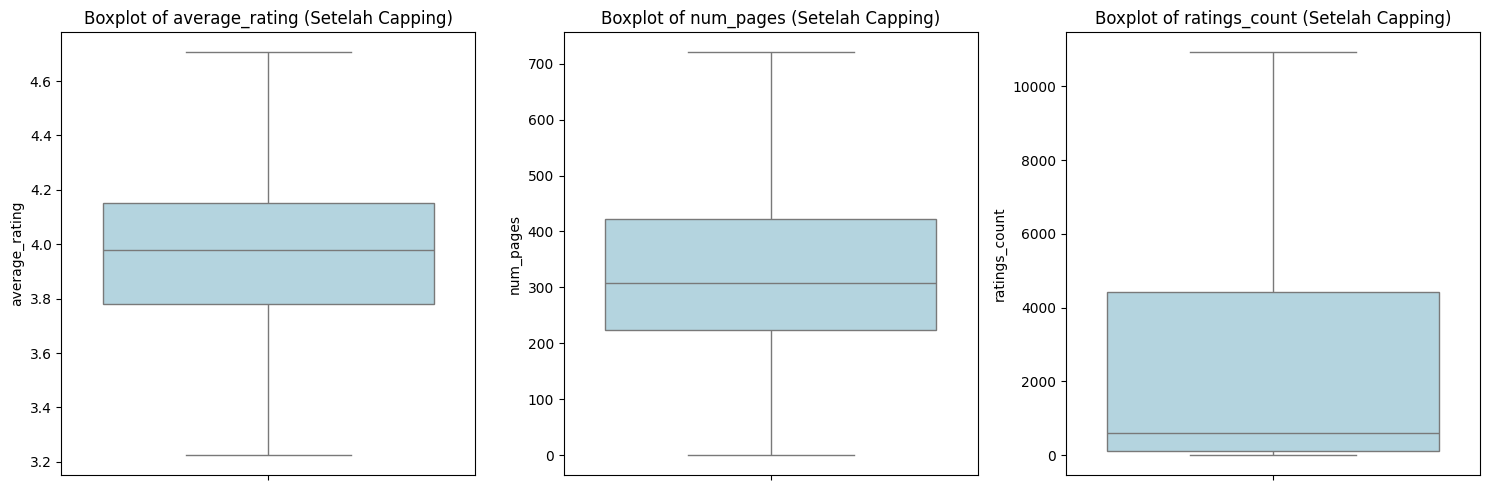

Outlier ditangani dengan metode capping (Membatasi Outlier ke Batas IQR).


In [164]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

df_capped = df.copy()

# Mendefinisikan visualisasi boxplot
numerical_cols_for_boxplot = ['average_rating', 'num_pages', 'ratings_count']

for col in numerical_cols_for_boxplot:
    _, lower, upper = detect_outliers_iqr(df_capped, col)
    df_capped[col] = np.where(df_capped[col] < lower, lower, df_capped[col])
    df_capped[col] = np.where(df_capped[col] > upper, upper, df_capped[col])

# Boxplot setelah capping (Membatasi Outlier ke Batas IQR))
# Update the subplot parameters to match the number of columns being plotted
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols_for_boxplot):
    # Change 1, 3 to match the number of columns in numerical_cols_for_boxplot (which is 3)
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df_capped[col], color='lightblue')
    plt.title(f'Boxplot of {col} (Setelah Capping)')
plt.tight_layout()
plt.show()

print("Outlier ditangani dengan metode capping (Membatasi Outlier ke Batas IQR).")

Insight: sudah tidak terdapat outliers. outliers di-handling menggunakan teknik capping (membatasi outlier ke batas IQR)

## Text Preprocessing (untuk Content-Based Filtering)


In [166]:
# Menggabungkan fitur
df['combined_features'] = df['title'] + ' ' + df['authors'] + ' ' + df['categories'] + ' ' + df['description'] + ' ' + df['average_rating'].astype(str)

Insight: teks yang bersih membantu mempermudah dalam menganalisis kata, pembuatan fitur berbasis konten (TF-IDF), atau analisis sentimen.

In [168]:
# Definisikan fungsi preprocessing teks
stemmer = PorterStemmer()

def preprocess_text(text):
    # Ubah ke huruf kecil
    text = text.lower()
    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Tokenisasi
    tokens = nltk.word_tokenize(text)
    # Hapus stopwords dan lakukan stemming
    cleaned_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Gabungkan kembali
    return ' '.join(cleaned_tokens)

# preprocessing pada kolom 'description'
df['description_clean'] = df['description'].apply(preprocess_text)

# Contoh hasil cleaning
print("Contoh hasil pembersihan teks:")
print("\nDeskripsi asli:\n", df['description'].iloc[0][:300])
print("\nDeskripsi setelah preprocessing:\n", df['description_clean'].iloc[0][:300])

Contoh hasil pembersihan teks:

Deskripsi asli:
 A new 'Christie for Christmas' -- a full-length novel adapted from her acclaimed play by Charles Osborne Following BLACK COFFEE and THE UNEXPECTED GUEST comes the final Agatha Christie play novelisation, bringing her superb storytelling to a new legion of fans. Clarissa, the wife of a Foreign Office

Deskripsi setelah preprocessing:
 new christi christma fulllength novel adapt acclaim play charl osborn follow black coffe unexpect guest come final agatha christi play novelis bring superb storytel new legion fan clarissa wife foreign offic diplomat given daydream suppos come one morn find dead bodi librari muse clarissa chanc find


Insight: Setelah dibersihkan, teks deskripsi menjadi lebih ringkas dan berisi kata-kata kunci yang lebih relevan.

## Normalisasi/Standarisasi (untuk fitur numerik)

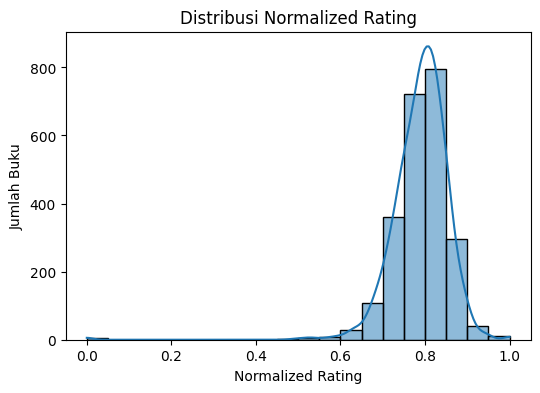

In [165]:
scaler = MinMaxScaler()
df[['average_rating', 'num_pages', 'ratings_count']] = scaler.fit_transform(df[['average_rating', 'num_pages', 'ratings_count']])

# Cek distribusi rating setelah normalisasi
plt.figure(figsize=(6, 4))
sns.histplot(df['average_rating'], bins=20, kde=True)
plt.title('Distribusi Normalized Rating')
plt.xlabel('Normalized Rating')
plt.ylabel('Jumlah Buku')
plt.show()

Insight:
Setelah normalisasi, data berada dalam rentang 0.0 hingga 1.0. Namun, distribusi data tetap miring ke kiri (left-skewed). Ini menunjukkan bahwa sebagian besar rating (setelah dinormalisasi) masih terkonsentrasi pada nilai-nilai yang tinggi (0.7-0.9), dan ada sebagian kecil rating yang relatif rendah (mendekati 0). Proses normalisasi berhasil dalam menskalakan data ke rentang yang diinginkan, tetapi tidak mengubah bentuk intrinsik atau kemiringan distribusi aslinya.

# Membangun Model Rekomendasi

## Collaborative Filtering

### Matriks Interaksi (untuk Collaborative Filtering)

In [171]:
# Simulasi user_id
np.random.seed(42)
num_users = 5000
df['user_id'] = np.random.choice([f'user_{i}' for i in range(1, num_users+1)], size=len(df))

# Pastikan rating berupa float (jika belum)
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')

Insight:
* Karena dataset belum memiliki kolom user_id, kode ini mensimulasikan data pengguna sebanyak 5.000 user yang akan digunakan untuk membentuk user-item interaction matrix dalam collaborative filtering.
* langkah ini penting dilakukan sebelum melakukan analisis atau modeling (seperti prediksi rating, filtering item dengan rating tinggi).

In [172]:
# User-Item Matrix: baris = user, kolom = buku (isbn13), isi = rating
user_item_matrix = df.pivot_table(index='user_id', columns='isbn13', values='average_rating')

print("Ukuran User-Item Matrix:", user_item_matrix.shape)
user_item_matrix.head()

Ukuran User-Item Matrix: (1888, 2379)


isbn13,9780002261982,9780006380832,9780006470229,9780006499626,9780006551812,9780006754893,9780007105045,9780007116263,9780007135653,9780007137336,...,9782884490474,9782940373154,9783125738089,9783425040844,9783791329284,9783856305581,9784766113389,9784770028037,9788185300535,9789042003408
user_id,,,,,,,,,,,,,,,,,,,,,
user_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Insight:
* Membuat user-item interaction matrix, yaitu bentuk data yang umum digunakan untuk Collaborative Filtering.
* terlihat dari table yang ditampilkan bahwa sebagian besar nilai di matriks ini adalah NaN, hal itu karena tidak semua user memberi rating ke semua buku. Ini menunjukkan seberapa sparse (jarang diisi) dari matriks interaksi, yang merupakan ciri umum dalam sistem rekomendasi.

* Cosine Similarity untuk Collaborative Filtering (Item-Based)

In [216]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer

# Cosine similarity antara item (berdasarkan user rating)
imputer = SimpleImputer(strategy='constant', fill_value=0)
item_matrix = imputer.fit_transform(user_item_matrix.T)
similarity_matrix = cosine_similarity(item_matrix)

Insight:
* Data dipersiapkan agar dapat dihitung kesamaan antar item berdasarkan vektor rating dari para user.
* dikarenakan besar matrik bernilai NaN, maka NaN diganti dengan 0 sebagai pendekatan untuk membangun item-based recommender menggunakan similarity.

In [219]:
# Prediksi rating: dot product dari similarity matrix dan user-item matrix
pred_ratings = user_item_matrix.fillna(0).dot(similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])

# Hasilnya adalah prediksi rating untuk semua user dan buku
print("Prediksi rating shape:", pred_ratings.shape)

Prediksi rating shape: (1888, 2379)


Insight:
* Ini merupakan implementasi sederhana dari item-based collaborative filtering berbasis similarity antar item.
* Menghasilkan prediksi rating dari user terhadap item yang belum pernah mereka rating, berdasarkan kemiripan item.
* Matriks berukuran (jumlah_user, jumlah_item) yang berisi nilai prediksi rating, siap digunakan untuk menyusun rekomendasi personal

In [189]:
def recommend_books(isbn, top_n=5):
    if isbn not in similarity_matrix.columns:
        return f"Buku dengan ISBN {isbn} tidak ditemukan."

    similar_scores = similarity_matrix[isbn].sort_values(ascending=False)
    top_similar = similar_scores.iloc[1:top_n+1]  # skip indeks pertama karena itu dirinya sendiri

    return df[df['isbn13'].isin(top_similar.index)][['title', 'authors', 'average_rating']]

In [176]:
# Ganti dengan ISBN yang valid di dataset
isbn_sample = df['isbn13'].iloc[0]
print("Rekomendasi buku mirip dengan:", df[df['isbn13'] == isbn_sample]['title'].values[0])
recommend_books(isbn_sample, top_n=5)

Rekomendasi buku mirip dengan: Spider's Web


,title,authors,average_rating
4831,The Power of One,John C. Maxwell;Thomas G. Addington,0.856
4833,Only the River Runs Free,Bodie Thoene;Brock Thoene,0.818
4834,The Blood of the Moon,George Grant,0.738
4836,The Complete Dream Dictionary,Pamela Ball,0.744
4845,Night Lives,Phyllis Eisenstein;Alex Eisenstein,0.900


In [190]:
def recommend_books_by_title(title_input, top_n=5):
    title_input = title_input.lower()

    # Cari judul buku yang cocok atau paling mendekati
    matched_books = df[df['title'].str.lower().str.contains(title_input, na=False)]

    if matched_books.empty:
        return f"Buku dengan judul mengandung '{title_input}' tidak ditemukan."

    # Ambil ISBN dari buku pertama yang cocok
    matched_book = matched_books.iloc[0]
    matched_title = matched_book['title']
    matched_isbn = matched_book['isbn13']

    # Tampilkan info buku input
    print(f"Menampilkan rekomendasi mirip dengan:\n→ Judul: {matched_title}\n→ ISBN: {matched_isbn}")

    # Ambil skor kemiripan dari item similarity matrix
    if matched_isbn not in similarity_matrix.columns:
        return f"ISBN {matched_isbn} tidak ditemukan dalam matriks rekomendasi."

    similar_scores = similarity_matrix[matched_isbn].sort_values(ascending=False)
    top_similar = similar_scores.iloc[1:top_n+1]

    # Ambil informasi buku-buku yang direkomendasikan
    recommended_books = df[df['isbn13'].isin(top_similar.index)][['title', 'authors', 'average_rating']].drop_duplicates()
    return recommended_books

In [178]:
# test sistem rekomendasi (user menginput sebagian judul buku)
book_name_input = input('Masukkan judul buku favoritmu: ')
recommend_books_by_title(book_name_input)

Masukkan judul buku favoritmu: 'I'm Telling You Stories'
Menampilkan rekomendasi mirip dengan:
→ Judul: 'I'm Telling You Stories'
→ ISBN: 9789042003408


,title,authors,average_rating
4831,The Power of One,John C. Maxwell;Thomas G. Addington,0.856
4834,The Blood of the Moon,George Grant,0.738
4836,The Complete Dream Dictionary,Pamela Ball,0.744
4845,Night Lives,Phyllis Eisenstein;Alex Eisenstein,0.900
6809,'I'm Telling You Stories',Helena Grice;Tim Woods,0.740


Insight:
* Fungsi di atas menunjukkan bahwa sistem dapat menerima input berupa sebagian judul buku dari pengguna, lalu memberikan daftar rekomendasi buku lain yang mirip berdasarkan kemiripan konten (item-item similarity). Dalam hal ini, kemiripan dihitung berdasarkan pola rating pengguna sebelumnya (menggunakan item-based collaborative filtering).
* Output di atas adalah judul buku yang diketik pengguna (misalnya: 'I'm Telling You Stories') yang dijadikan referensi untuk menelusuri buku-buku lain yang memiliki pola rating serupa dari para pembaca.

## Content Based Filtering

* Fungsi TF-IDF dan Cosine Similarity untuk algoritma CBF

In [233]:
# Vectorizer untuk deskripsi buku
tfidf = TfidfVectorizer(stop_words='english')
# Pastikan tidak ada nilai NaN di kolom deskripsi
df['description'] = df['description'].fillna('')
# Bentuk matriks TF-IDF
tfidf_matrix = tfidf.fit_transform(df['description'])

# Hitung similarity antar semua buku berdasarkan deskripsi
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [232]:
# Fungsi rekomendasi berdasarkan konten
def recommend_books(title_input, top_n=5):
    all_titles = df['title'].tolist()
    close_matches = difflib.get_close_matches(title_input, all_titles, n=1, cutoff=0.6)

    if not close_matches:
        return f"Tidak ditemukan buku dengan judul mendekati '{title_input}'."

    matched_title = close_matches[0]
    print(f"Mencari berdasarkan judul terdekat: '{matched_title}'")

    # Ambil indeks buku dalam dataframe
    idx = df[df['title'] == matched_title].index[0]

    # Ambil skor similarity dengan semua buku lain
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Ambil indeks buku yang direkomendasikan
    book_indices = [i[0] for i in sim_scores]
    recommended_books = df.iloc[book_indices].drop_duplicates(subset=['isbn13'])

    return recommended_books[['title', 'authors', 'description']]

# Testing
book_name_input = input('Masukkan judul buku favoritmu: ')
recommend_books(book_name_input)

Masukkan judul buku favoritmu: I'm Telling You Stories
Mencari berdasarkan judul terdekat: ''I'm Telling You Stories''


,title,authors,description
1735,Superheroes and Philosophy,Thomas V. Morris;Matt Morris;William Irwin,A collection of essays by various authors that...
327,The Double Flame,Octavio Paz,A collection of essays examines the themes of ...
931,"Where We Are, what We See",David Levithan,"A collection of poems, stories, essays, and ar..."
1066,The Responsibility of Forms,Roland Barthes,These late essays of Roland Barthes's are conc...
1736,Star Wars and Philosophy,Kevin S. Decker;William Irwin;Jason T. Eberl,A collection of essays that address the philos...


Insight:
* Kode di atas berhasil merekomendasikan buku-buku yang memiliki kemiripan secara isi (konten) dengan buku yang dicari oleh pengguna berdasarkan deskripsinya. Sistem ini tidak memerlukan data dari pengguna lain, melainkan fokus pada informasi intrinsik dari buku seperti deskripsi (description), dan menggunakan matriks kesamaan (similarity matrix) yang dibentuk dari deskripsi melalui teknik seperti TF-IDF dan cosine similarity.
* Berdasarkan contoh input **“I'm Telling You Stories”**, sistem berhasil mencocokkan judul terdekat dan kemudian mengembalikan daftar buku yang memiliki topik serupa atau gaya penulisan sejenis, yaitu kumpulan esai, cerita filosofis, atau literatur reflektif. Hal ini menunjukkan bahwa sistem cukup efektif dalam menangkap nuansa tema atau gaya konten dari buku input dan mencari padanannya di koleksi yang ada.

# Evaluasi

### Fungsi Metrik Evaluasi

In [194]:
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_count = len(set(recommended_at_k) & set(relevant_items))
    return relevant_count / k

def recall_at_k(recommended_items, relevant_items, k):
    if len(relevant_items) == 0:
        return 0.0
    recommended_at_k = recommended_items[:k]
    relevant_count = len(set(recommended_at_k) & set(relevant_items))
    return relevant_count / len(relevant_items)

def reciprocal_rank(recommended_items, relevant_items):
    for rank, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            return 1 / rank
    return 0.0

def coverage(all_recommendations, total_items):
    unique_recommended = set(item for user_rec in all_recommendations.values() for item in user_rec)
    return len(unique_recommended) / total_items

In [220]:
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_count = len(set(recommended_at_k) & set(relevant_items))
    return relevant_count / k if k > 0 else 0.0

def recall_at_k(recommended_items, relevant_items, k):
    if len(relevant_items) == 0:
        return 0.0
    recommended_at_k = recommended_items[:k]
    relevant_count = len(set(recommended_at_k) & set(relevant_items))
    return relevant_count / len(relevant_items)

def f1_score_at_k(recommended_items, relevant_items, k):
    p = precision_at_k(recommended_items, relevant_items, k)
    r = recall_at_k(recommended_items, relevant_items, k)
    if (p + r) == 0:
        return 0.0
    return (2 * p * r) / (p + r)

def reciprocal_rank(recommended_items, relevant_items):
    for rank, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            return 1 / rank
    return 0.0

def hit_rate_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    # Cek apakah ada irisan antara item yang direkomendasikan dan item yang relevan
    if len(set(recommended_at_k) & set(relevant_items)) > 0:
        return 1.0
    return 0.0

def coverage(all_recommendations_list, total_items_count):
    unique_recommended = set(all_recommendations_list)
    return len(unique_recommended) / total_items_count if total_items_count > 0 else 0.0

#### Fungsi Metrik Evaluasi Content-Based Filtering

In [234]:
def evaluate_content_based(df, similarity, top_k=5):
    precision_list, recall_list, f1_list, mrr_list, hit_list = [], [], [], [], []
    all_recommended_ids_for_coverage = []
    total_items = len(df)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating CBF"):
        sim_scores = list(enumerate(similarity[idx]))

        # Urutkan buku berdasarkan skor kesamaan (tertinggi ke terendah)
        # Ambil top_k+1 karena indeks pertama adalah buku itu sendiri
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_k+1]

        # Ambil ID buku yang direkomendasikan
        recommended_ids = [i[0] for i in sim_scores]
        relevant_ids = [idx]

        # Hitung metrik untuk iterasi saat ini
        p_at_k = precision_at_k(recommended_ids, relevant_ids, top_k)
        r_at_k = recall_at_k(recommended_ids, relevant_ids, top_k)
        f1_at_k = f1_score_at_k(recommended_ids, relevant_ids, top_k)
        rr = reciprocal_rank(recommended_ids, relevant_ids)
        hr_at_k = hit_rate_at_k(recommended_ids, relevant_ids, top_k)

        # Tambahkan ke daftar
        precision_list.append(p_at_k)
        recall_list.append(r_at_k)
        f1_list.append(f1_at_k)
        mrr_list.append(rr)
        hit_list.append(hr_at_k)
        all_recommended_ids_for_coverage.extend(recommended_ids)

    # Hitung rata-rata semua metrik
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1_score = np.mean(f1_list)
    avg_mrr = np.mean(mrr_list)
    avg_hit_rate = np.mean(hit_list)
    total_unique_books_in_catalog = df.index.nunique() # Menggunakan jumlah indeks unik sebagai total item
    final_coverage = coverage(all_recommended_ids_for_coverage, total_unique_books_in_catalog)


    print("\n--- Content-Based Filtering Evaluation Results ---")
    print(f"Precision@{top_k}: {avg_precision:.4f}")
    print(f"Recall@{top_k}: {avg_recall:.4f}")
    print(f"F1-Score@{top_k}: {avg_f1_score:.4f}") # Metrik baru
    print(f"MRR: {avg_mrr:.4f}")
    print(f"Hit Rate@{top_k}: {avg_hit_rate:.4f}") # Metrik baru
    print(f"Coverage: {final_coverage:.4f}")

In [235]:
# Evaluasi CBF
evaluate_content_based(df, similarity_matrix, top_k=5)

Evaluating CBF: 100%|██████████| 2379/2379 [00:02<00:00, 878.13it/s]


--- Content-Based Filtering Evaluation Results ---
Precision@5: 0.0013
Recall@5: 0.0067
F1-Score@5: 0.0022
MRR: 0.0060
Hit Rate@5: 0.0067
Coverage: 0.8878


#### Fungsi Metrik Evaluasi Collaborative Filtering

In [226]:
def evaluate_collaborative(user_item_matrix, pred_ratings, top_k=5):
    precision_list, recall_list, f1_list, mrr_list, hit_list = [], [], [], [], []
    all_recommended_ids_for_coverage = [] # Untuk mengumpulkan semua ID buku yang direkomendasikan
    total_items = user_item_matrix.shape[1] # Total buku unik dalam katalog

    if isinstance(pred_ratings, pd.DataFrame):
        pred_ratings_values = pred_ratings.values
    else:
        pred_ratings_values = pred_ratings

    for idx, (user_id_label, true_ratings_series) in tqdm(enumerate(user_item_matrix.iterrows()),
                                                           total=len(user_item_matrix),
                                                           desc="Evaluating CF"):
        true_ratings = true_ratings_series.values
        predicted = pred_ratings_values[idx]

        relevant_indices = np.where(true_ratings >= 0.8)[0]
        # Mengubah indeks relevan menjadi ID buku yang sebenarnya (nama kolom)
        relevant_book_ids = list(user_item_matrix.columns[relevant_indices])

        # Urutkan buku berdasarkan prediksi rating tertinggi
        # Ambil indeks kolom dari rating yang diprediksi
        recommended_indices = np.argsort(predicted)[::-1]
        # Ubah indeks menjadi ID buku yang sebenarnya (nama kolom)
        recommended_book_ids = list(user_item_matrix.columns[recommended_indices])

        # Ambil top_k rekomendasi
        recommended_at_k = recommended_book_ids[:top_k]

        # Hitung metrik untuk iterasi saat ini
        p_at_k = precision_at_k(recommended_at_k, relevant_book_ids, top_k)
        r_at_k = recall_at_k(recommended_at_k, relevant_book_ids, top_k)
        f1_at_k = f1_score_at_k(recommended_at_k, relevant_book_ids, top_k)
        rr = reciprocal_rank(recommended_book_ids, relevant_book_ids)
        hr_at_k = hit_rate_at_k(recommended_at_k, relevant_book_ids, top_k)

        # Tambahkan ke daftar
        precision_list.append(p_at_k)
        recall_list.append(r_at_k)
        f1_list.append(f1_at_k)
        mrr_list.append(rr)
        hit_list.append(hr_at_k)
        all_recommended_ids_for_coverage.extend(recommended_at_k)

    # Hitung rata-rata semua metrik
    avg_precision = np.mean(precision_list) if precision_list else 0.0
    avg_recall = np.mean(recall_list) if recall_list else 0.0
    avg_f1_score = np.mean(f1_list) if f1_list else 0.0
    avg_mrr = np.mean(mrr_list) if mrr_list else 0.0
    avg_hit_rate = np.mean(hit_list) if hit_list else 0.0

    # Coverage menggunakan total item dari user_item_matrix
    final_coverage = coverage(all_recommended_ids_for_coverage, total_items)


    print("\n--- Collaborative Filtering Evaluation Results ---")
    print(f"Precision@{top_k}: {avg_precision:.4f}")
    print(f"Recall@{top_k}: {avg_recall:.4f}")
    print(f"F1-Score@{top_k}: {avg_f1_score:.4f}")
    print(f"MRR: {avg_mrr:.4f}")
    print(f"Hit Rate@{top_k}: {avg_hit_rate:.4f}")
    print(f"Coverage: {final_coverage:.4f}")

In [227]:
# Collaborative (misalnya dengan matrix factorization atau SVD)
evaluate_collaborative(user_item_matrix, pred_ratings, top_k=5)

Evaluating CF: 100%|██████████| 1888/1888 [00:01<00:00, 1214.75it/s]


--- Collaborative Filtering Evaluation Results ---
Precision@5: 0.0947
Recall@5: 0.4459
F1-Score@5: 0.1551
MRR: 0.1054
Hit Rate@5: 0.4735
Coverage: 0.7945


## Analisis Komparatif pada Metrik Evaluasi

Dari hasil evaluasi di atas, terlihat perbedaan kinerja yang sangat signifikan antara kedua pendekatan, mari kita bahas lebih detail dengan mengaitkannya dengan problem statement (PS) dan goals dalam proyek ini:

**1. Relevansi dan Personalisasi (Menjawab PS1 & Goal 2):**
* Collaborative Filtering (CF) jelas menunjukkan performa yang jauh lebih unggul dalam menyajikan rekomendasi yang relevan dan personal. Dengan Precision@5 sebesar 0.0947, artinya dari setiap 5 rekomendasi yang diberikan CF, rata-rata hampir 1 buku (sekitar 0.47 atau 47% dari 5 rekomendasi) adalah buku yang relevan dan mungkin disukai pengguna. Ini jauh lebih baik dibandingkan CBF yang memiliki Precision@5 hanya 0.0013, yang berarti sangat sedikit dari 5 rekomendasi CBF yang relevan.
* Recall@5 CF (0.4459) yang jauh lebih tinggi daripada CBF (0.0067) menunjukkan bahwa CF lebih mampu menangkap proporsi yang lebih besar dari semua buku relevan yang seharusnya direkomendasikan kepada pengguna.
* F1-Score@5 mengkonfirmasi dominasi CF (0.1551) atas CBF (0.0022), yang berarti CF memiliki keseimbangan yang jauh lebih baik antara ketepatan dan cakupan rekomendasi.

**2. Efisiensi Penemuan Buku (Menjawab PS2 & Goal 2):**
* MRR (Mean Reciprocal Rank) CF (0.1054) yang lebih tinggi menunjukkan bahwa ketika CF berhasil merekomendasikan buku yang relevan, buku tersebut cenderung muncul lebih awal dalam daftar rekomendasi dibandingkan CBF (0.0060). Hal ini sangat penting untuk kenyamanan pengguna, karena mereka tidak perlu menggulir terlalu jauh untuk menemukan sesuatu yang mereka minati.
* Hit Rate@5 CF (0.4735) secara signifikan lebih tinggi dari CBF (0.0067). Ini berarti hampir setengah dari pengguna (sekitar 47.35%) akan menemukan setidaknya satu buku relevan dalam 5 rekomendasi teratas yang diberikan CF, dibandingkan dengan CBF yang hampir tidak pernah memberikan hit relevan dalam 5 teratas. Ini adalah indikator langsung keberhasilan sistem dalam membantu pengguna menemukan buku.

**3. Potensi Retensi dan Kepuasan Pengguna (Menjawab PS3 & Goal 3):**
* Kinerja CF yang superior dalam metrik relevansi (Precision, Recall, F1-Score, MRR, Hit Rate) secara langsung mendukung tujuan peningkatan retensi dan kepuasan pengguna. Ketika pengguna secara konsisten menerima rekomendasi yang relevan dan berguna, pengalaman mereka di platform akan meningkat, mendorong mereka untuk lebih sering kembali dan merasa lebih puas.

**4. Cakupan Rekomendasi:**
* Coverage CBF (0.8878) lebih tinggi daripada CF (0.7945). Ini menunjukkan bahwa model CBF memiliki kemampuan untuk merekomendasikan proporsi buku yang lebih besar dari keseluruhan katalog (hampir 89%), dibandingkan CF (sekitar 79%). Meskipun CBF menawarkan cakupan yang lebih luas, relevansi rendahnya menjadi masalah. CF, di sisi lain, lebih efisien dalam menemukan rekomendasi yang relevan, meskipun mungkin pada subset buku yang lebih kecil. Ini mengindikasikan bahwa CBF tidak menderita masalah cold start pada item baru seperti halnya CF, namun rekomendasi yang diberikan seringkali tidak "tepat sasaran".

**Kesimpulan Hasil Proyek**:
Berdasarkan hasil evaluasi ini, **Collaborative Filtering** (CF) terbukti menjadi pendekatan yang lebih efektif dan akurat dalam menyediakan rekomendasi buku yang relevan dan personal, serta secara signifikan meningkatkan peluang pengguna menemukan buku yang mereka sukai. CF lebih mampu menangkap pola preferensi pengguna dan memberikan rekomendasi yang berdampak positif pada pengalaman penemuan buku.

Meskipun demikian, **Content-Based Filtering** menunjukkan potensi dalam hal cakupan yang luas, yang bisa menjadi aset untuk mengatasi masalah cold start pada buku-buku baru atau niche yang belum banyak memiliki interaksi.